# **Initialization** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

### Control

In [23]:
# Paths
RAW_DATA_FOLDER = 'raw_data'
TARGET_FILE_PATH = 'unprocessed_data'

# Flow Controls
RELOAD_RAW_DATA = False
DO_SMOTE = True
DATA = 'depression'  # Options: 'depression', 'insomnia', 'electrical_circuit'

# System variables
STATE = 42
TEST_SET_FRACTION = 0.20
MISSING_VALUES_THRESHOLD = 0.50
SAMPLES_ELECTRICAL_CIRCUIT = 5000
VERBOSE = True
FLIP_LABEL_FRACTION = 0.03

np.random.seed(STATE)

# **Data Preparation**

### Merge raw data files

In [24]:
from raw_data_loader import load_raw_data

if (RELOAD_RAW_DATA):
    load_raw_data(RAW_DATA_FOLDER, TARGET_FILE_PATH)

### Preprocessing and Split

In [25]:
from preprocessing_depression import clean_and_preprocess_depression_data
from preprocessing_insomnia import clean_and_preprocess_insomnia_data
from preprocessing_electrical_circuit import gen_and_preprocess_ec_data

dataset = pd.read_csv(TARGET_FILE_PATH + '/' + DATA + '_data.csv')

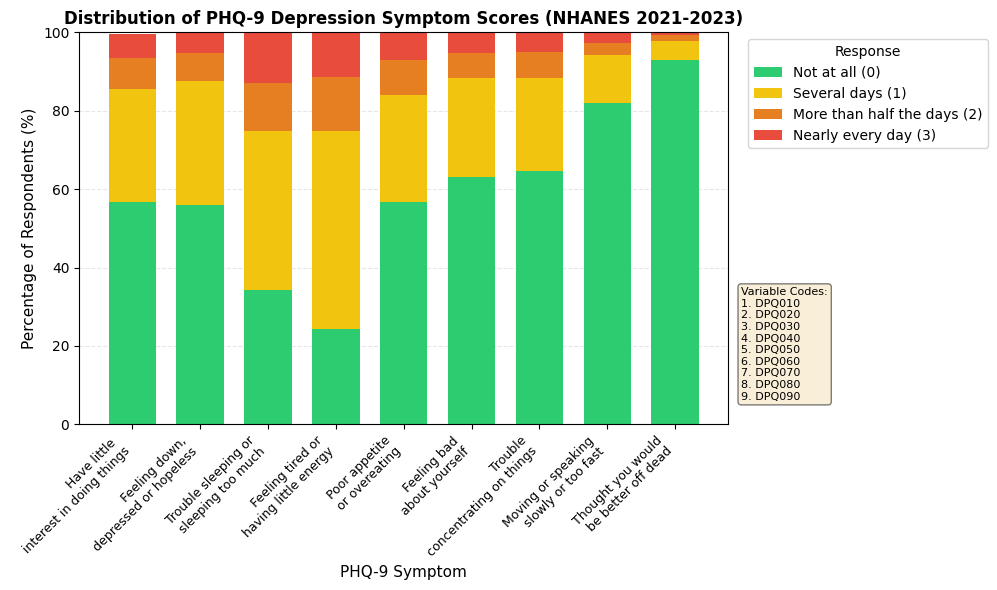


=== PHQ-9 Score Distribution Summary ===
Total respondents: 4167

Percentage with score ≥2 (symptom present) per item:
  Have little  interest in doing things: 14.4%
  Feeling down, depressed or hopeless: 12.3%
  Trouble sleeping or sleeping too much: 25.1%
  Feeling tired or having little energy: 25.1%
  Poor appetite or overeating: 15.9%
  Feeling bad about yourself: 11.6%
  Trouble concentrating on things: 11.6%
  Moving or speaking slowly or too fast: 5.9%
  Thought you would be better off dead: 2.2%


In [26]:
from visualizations import plot_phq9_distribution

if DATA == 'depression':
    plot_phq9_distribution(dataset, save_path='./visualizations/phq9_distribution.png')

In [ ]:
if DATA == 'depression':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_depression_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD, False)
elif DATA == 'insomnia':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_insomnia_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD, False)
    DO_SMOTE = False
elif DATA == 'electrical_circuit':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = gen_and_preprocess_ec_data(SAMPLES_ELECTRICAL_CIRCUIT, TEST_SET_FRACTION, STATE, False)
    DO_SMOTE = False
else:
    raise ValueError("Invalid dataset selected")

#TODO Fix issue with the time columns SLQ300/310/320/330 in depression and processing

Dropped 142 columns with >50.0% missing values
Shape after dropping high-missing columns: (3333, 109)
Replaced 708 special code values with NaN
Replaced 186 special code values with NaN
Ordinal columns: 27
Nominal columns: 3
Binary columns: 55
Numerical columns: 21
Object columns (excluded): 2
Total columns identified: 108


### Data Balancing

In [28]:
from data_balancing import resample_training_data

if DO_SMOTE:
    X_train, y_train, y_embed_train = resample_training_data(X_train, y_train, y_embed_train, random_state=STATE)

In [29]:
# Check class distribution
classes, counts = np.unique(y_train, return_counts=True)
print("Class Distribution:\n", dict(zip(classes, counts)))

if len(classes) > 1:
    class_ratio = counts[1] / counts[0]
    print(f"\nClass ratio: {class_ratio:.3f}")
else:
    print("\nOnly one class present.")

Class Distribution:
 {np.int64(0): np.int64(3113), np.int64(1): np.int64(3011)}

Class ratio: 0.967


### Introduce Noise to label

In [30]:
assert FLIP_LABEL_FRACTION > 0.0 and FLIP_LABEL_FRACTION < 1.0, "FLIP_LABEL_FRACTION should be beween 0.0 and 1.0"

# Randomly select indices to flip
if FLIP_LABEL_FRACTION > 0.0:
    num_to_flip = int(FLIP_LABEL_FRACTION * len(y_train))
    flip_indices = np.random.choice(len(y_train), size=num_to_flip, replace=False)

    # If y_train is a pandas Series, convert to int for safe arithmetic
    if hasattr(y_train, 'iloc'):
        y_train = y_train.astype(int)
        y_train.iloc[flip_indices] = 1 - y_train.iloc[flip_indices]
    else:  # numpy array
        y_train[flip_indices] = 1 - y_train[flip_indices]

### Make everything a numpy array

In [31]:
X_train = X_train.values if hasattr(X_train, "values") else np.array(X_train)
X_test = X_test.values if hasattr(X_test, "values") else np.array(X_test)

y_train = y_train.values.ravel() if hasattr(y_train, "values") else np.array(y_train).ravel()
y_test = y_test.values.ravel() if hasattr(y_test, "values") else np.array(y_test).ravel()

y_embed_train = y_embed_train.values if hasattr(y_embed_train, "values") else np.array(y_embed_train)
y_embed_test = y_embed_test.values if hasattr(y_embed_test, "values") else np.array(y_embed_test)

assert(isinstance(X_train, np.ndarray))
assert(isinstance(X_test, np.ndarray))
assert(isinstance(y_train, np.ndarray))
assert(isinstance(y_test, np.ndarray))
assert(isinstance(y_embed_train, np.ndarray))
assert(isinstance(y_embed_test, np.ndarray))

# **Models**

In [32]:
from baseline_models import train_multitarget_baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### Training Bayesian Models

In [ ]:
nb_model = GaussianNB()
y_pred_nb, _= train_multitarget_baseline(
                            model=nb_model,
                            is_classifier=False,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## GaussianNB Multitarget Regressor ########################################
Train MSE per embedding: [1.39973873 1.46227956 1.74003919 1.14941215 1.35009798 1.5324951
 2.34225996 4.79408883 4.26143044]
Test MSE per embedding: [1.71807229 2.1626506  1.9060241  1.55662651 1.74337349 2.13373494
 2.9253012  5.60843373 4.5060241 ]
Average train MSE: 2.225760214819653
Average test MSE: 2.695582329317269


### Training Random Forests

In [ ]:
# Parameter
N_ESTIMATORS = 100

In [ ]:
rf_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=STATE, n_jobs=-1)
y_pred_rf, _ = train_multitarget_baseline(
                                    model=rf_model, 
                                    is_classifier=False, 
                                    X_train=X_train, 
                                    X_test=X_test, 
                                    y_embed_train=y_embed_train, 
                                    y_embed_test=y_embed_test,
                                    verbose=VERBOSE)



 ######################################## RandomForestRegressor Multitarget Regressor ########################################
Train MSE per embedding: [0.04809364 0.03888806 0.06587294 0.05175765 0.05527564 0.04570145
 0.04373856 0.0284294  0.01325846]
Test MSE per embedding: [0.65898503 0.55432488 0.82723705 0.70263783 0.74023883 0.58848958
 0.57027756 0.40489108 0.19854584]
Average train MSE: 0.043446199379490485
Average test MSE: 0.5828475200803213


### Training Logistic Models

In [36]:
# Parameters
MAX_ITERATIONS = 1000

In [ ]:
log_model = LogisticRegression(max_iter=MAX_ITERATIONS, class_weight='balanced', random_state=STATE)
y_pred_log, _ = train_multitarget_baseline(
                            model=log_model,
                            is_classifier=False,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## LogisticRegression Multitarget Regressor ########################################
Train MSE per embedding: [0.90512737 0.71734161 1.02743305 0.82446114 1.02612671 0.8251143
 0.82217505 0.83703462 0.64549314]
Test MSE per embedding: [1.28433735 1.05662651 1.5313253  1.26144578 1.31686747 1.14457831
 1.25180723 1.10963855 0.81566265]
Average train MSE: 0.8478118876551273
Average test MSE: 1.1969210174029452


## Proposed MLPs

In [38]:
from proposed_models import train_joint_model, train_split_model, train_deep_joint_model, train_deep_split_model

DEVICE = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
E_KEEP_RATE = 0.7
l = 1
if DATA == 'depression':
    l = 1e-2
elif DATA == 'insomnia':
    l = 1e-2
elif DATA == 'electrical_circuit':
    l = 1

EPOCHS = 100
AUGMENT_EPOCHS = EPOCHS//2
EARLY_STOP_EPOCHS = EPOCHS//5

In [39]:
# Sanity Checks
print("Using ", DEVICE, " for torch")

assert X_train.shape[0] >= 100 and y_train.shape[0] >= 100 and y_embed_train.shape[0] >= 100, "Arrays must have at least 100 samples for the check."

aligned = (len(X_train[:100]) == len(y_train[:100])) and (len(X_train[:100]) == len(y_embed_train[:100]))
assert aligned, "First 100 samples of X_train, y_train, and y_embed_train are not aligned."

Using  cpu  for torch


### Train Joint MLP

In [40]:
train_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test,
                    e_kept_ratio=E_KEEP_RATE,
                    l=l,
                    epochs=EPOCHS,
                    augment_epochs=AUGMENT_EPOCHS,
                    early_stop_epochs=EARLY_STOP_EPOCHS,
                    device=DEVICE
                  )

Training:	##################################################	[100.0%]

===========================   Joint MLP [Training]   ===========================
Regression Results:
MSE:	0.652018666267395


Classification Results:
F1 score: 0.9718423169750603
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3019
           1       0.99      0.95      0.97      1267

    accuracy                           0.98      4286
   macro avg       0.99      0.97      0.98      4286
weighted avg       0.98      0.98      0.98      4286

Confusion matrix:
 [[3008   11]
 [  59 1208]]
===========================   Joint MLP [Testing]   ===========================
Regression Results:
MSE:	0.7313761711120605


Classification Results:
F1 score: 0.23423423423423423
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       772
           1       0.25      0.22      0.23        58

    accuracy                     

### Train Split MLP

In [41]:
train_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test,
                    e_kept_ratio=E_KEEP_RATE,
                    epochs=EPOCHS,
                    augment_epochs=AUGMENT_EPOCHS,
                    early_stop_epochs=EARLY_STOP_EPOCHS,
                    device=DEVICE
                  )

Training:	##################################################	[100.0%]

===========================   Split MLP [Training]   ===========================
Regression Results:
MSE:	0.18728747963905334


Classification Results:
F1 score: 0.8550671994188158
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3019
           1       0.79      0.93      0.86      1267

    accuracy                           0.91      4286
   macro avg       0.88      0.91      0.89      4286
weighted avg       0.92      0.91      0.91      4286

Confusion matrix:
 [[2710  309]
 [  90 1177]]
===========================   Split MLP [Testing]   ===========================
Regression Results:
MSE:	0.8989593982696533


Classification Results:
F1 score: 0.24858757062146894
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       772
           1       0.18      0.38      0.25        58

    accuracy                   

### Train Deep Joint Model

In [42]:
train_deep_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test,
                        e_kept_ratio=E_KEEP_RATE,
                        l=l,
                        epochs=EPOCHS,
                        augment_epochs=AUGMENT_EPOCHS,
                        early_stop_epochs=EARLY_STOP_EPOCHS,
                        device=DEVICE
                      )

Training:	##################################################	[100.0%]

========================   Deep Joint MLP [Training]   ========================
Regression Results:
MSE:	1.911672592163086


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      3019
           1       0.00      0.00      0.00      1267

    accuracy                           0.70      4286
   macro avg       0.35      0.50      0.41      4286
weighted avg       0.50      0.70      0.58      4286

Confusion matrix:
 [[3019    0]
 [1267    0]]
=========================   Deep Joint MLP [Testing]   =========================
Regression Results:
MSE:	1.0805991888046265


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       772
           1       0.00      0.00      0.00        58

    accuracy                           0.93       830
   macro a

c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Training:	##################################################	[100.0%]

===================   Deep Joint MLP (Augmented) [Testing]   ===================
Regression Results:
MSE:	1.0805991888046265


Classification Results:
F1 score: 0.13063063063063063
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.07      1.00      0.13        58

    accuracy                           0.07       830
   macro avg       0.03      0.50      0.07       830
weighted avg       0.00      0.07      0.01       830

Confusion matrix:
 [[  0 772]
 [  0  58]]


c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

### Train Deep Split Model

In [43]:
train_deep_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test,
                        e_kept_ratio=E_KEEP_RATE,
                        epochs=EPOCHS,
                        augment_epochs=AUGMENT_EPOCHS,
                        early_stop_epochs=EARLY_STOP_EPOCHS,
                        device=DEVICE
                      )

Training:	###############################################---	[94.0% - DONE]

========================   Deep Split MLP [Training]   ========================
Regression Results:
MSE:	1.9122519493103027


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      3019
           1       0.00      0.00      0.00      1267

    accuracy                           0.70      4286
   macro avg       0.35      0.50      0.41      4286
weighted avg       0.50      0.70      0.58      4286

Confusion matrix:
 [[3019    0]
 [1267    0]]
=========================   Deep Split MLP [Testing]   =========================
Regression Results:
MSE:	1.0726871490478516


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       772
           1       0.00      0.00      0.00        58

    accuracy                           0.93       830
   

c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Training:	##################################################	[100.0%]

===================   Deep Split MLP (Augmented) [Testing]   ===================
Regression Results:
MSE:	1.0726871490478516


Classification Results:
F1 score: 0.13063063063063063
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.07      1.00      0.13        58

    accuracy                           0.07       830
   macro avg       0.03      0.50      0.07       830
weighted avg       0.00      0.07      0.01       830

Confusion matrix:
 [[  0 772]
 [  0  58]]


c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _